In [1]:
from Data import Data
import dataset_prep_functions as data_prep
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt

## 1. Reading Data of Stock

In [2]:
data = Data('MSFT', '2009-01-01')

read unprocessed data


In [3]:
data.data_frame.head(3)

,price,volume,s&p500,ebit,total current assets,total current liabilities,net cash from total operating activities,gdp [USA],interest_rates [USA],unemployment [USA],inflation [USA]
2009-01-02,15.87,50084000.00,931.80,5187.09,38580.15,23742.09,10868.20,14394.08,0.25,12085.10,-0.35
2009-01-03,15.92,53881066.67,930.35,5167.48,38617.11,23743.48,10942.81,14393.62,0.25,12112.19,-0.34
2009-01-04,15.96,57678133.33,928.90,5147.88,38654.07,23744.88,11017.43,14393.16,0.25,12139.29,-0.34


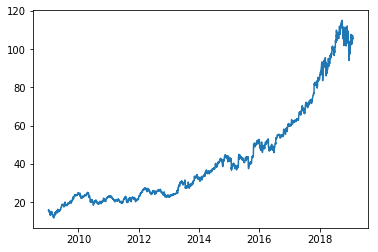

In [4]:
plt.plot(data.data_frame['price'])

## 2. Prepairing Data

In [5]:
# data configs
SUBSEQ_LEN = 100  # length of sequences fed into rnn
HORIZON = 50  # number of days predicted into future
VALID_RATIO = 0.1 # percent of validation data
BATCH_SIZE = 1

In [6]:
normalized_df, price_scaler = data_prep.normalize(data.data_frame)

In [7]:
# get non overlapping data sequences for later prediction test 
test_data_sequences = data_prep.get_subsequences(normalized_df.values, SUBSEQ_LEN, False)
fake_labels = np.zeros((test_data_sequences.shape[0], test_data_sequences.shape[1], HORIZON), dtype=np.float32)
test_data_sequences.shape, fake_labels.shape

((36, 100, 11), (36, 100, 50))

In [8]:
# split data into features x and labels y
x, y = data_prep.create_labels(normalized_df, HORIZON)
x.shape, y.shape

((3631, 11), (3631, 50))

In [9]:
# get overlapping subsequences of length SUBSEQ_LEN for features and labels
x_seq, y_seq = data_prep.get_subsequences(x, SUBSEQ_LEN), data_prep.get_subsequences(y,SUBSEQ_LEN)
x_seq.shape, y_seq.shape

((3531, 100, 11), (3531, 100, 50))

In [10]:
c = np.concatenate((x_seq,y_seq), axis=2)
#np.random.shuffle(c)
c.shape

(3531, 100, 61)

In [11]:
# split data into training and validation data based on chosen validation_ratio 
train, valid = data_prep.split(c, VALID_RATIO)

x_train, x_valid = train[:,:,:-HORIZON], valid[:,:,:-HORIZON]
y_train, y_valid = train[:,:,-HORIZON:], valid[:,:,-HORIZON:]

(x_train.shape, x_valid.shape), (y_train.shape, y_valid.shape)

(((3178, 100, 11), (353, 100, 11)), ((3178, 100, 50), (353, 100, 50)))

## 3. LSTM Configs

In [12]:
tf.reset_default_graph()

# lstm configs
INPUT_SIZE = x.shape[1]
OUTPUT_SIZE = y.shape[1]
LSTM_SIZES = [128, 64]

## 4. Computation Graph Definition

In [13]:
# batch placeholder
batchX = tf.placeholder(tf.float32, [BATCH_SIZE, SUBSEQ_LEN, INPUT_SIZE], name='batchX')
batchY = tf.placeholder(tf.float32, [BATCH_SIZE, SUBSEQ_LEN, OUTPUT_SIZE], name='batchY')

In [14]:
with tf.variable_scope("LSTM", reuse=tf.AUTO_REUSE) as scope:
    
    # state placeholder 
    c_in = [tf.placeholder(tf.float32, [BATCH_SIZE, s], name='c_{}'.format(c)) for c,s in enumerate(LSTM_SIZES)]
    h_in = [tf.placeholder(tf.float32, [BATCH_SIZE, s], name='h_{}'.format(c)) for c,s in enumerate(LSTM_SIZES)]
    
    # create LSTMCells
    lstm_layers = [tf.nn.rnn_cell.LSTMCell(size, activation='sigmoid', forget_bias=1.0) for size in LSTM_SIZES]

    # create a RNN cell composed sequentially of the created lstm cells
    multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_layers)

    state = tuple(tf.nn.rnn_cell.LSTMStateTuple(c, h) for c, h in zip(c_in, h_in))
    
    # 'outputs' is a tensor of shape [BATCH_SIZE, SUBSEQ_LEN, size_last_lstm_cell]
    # 'state' is a N-tuple where N is the number of LSTMCells containing a
    # tf.contrib.rnn.LSTMStateTuple for each cell
    outputs, final_state = tf.nn.dynamic_rnn(cell=multi_rnn_cell,
                                       inputs=batchX,
                                       initial_state=state,
                                       dtype=tf.float32)
    
    rnn_output = tf.transpose(outputs, [1,0,2]) 


In [15]:
with tf.variable_scope("ReadOut", reuse=tf.AUTO_REUSE) as scope:

    # Initialize all weights and biases.
    initializer = tf.random_normal_initializer(stddev=0.125)

    # readout
    Why = tf.get_variable("Why", [LSTM_SIZES[-1], OUTPUT_SIZE], initializer=initializer)
    by = tf.get_variable("by", [OUTPUT_SIZE], initializer=initializer)

    # logits calculation
    logits = tf.map_fn(lambda x: tf.matmul(x, Why) + by, rnn_output)
    logits = tf.transpose(logits, [1,0,2])

## 5. Definition of Metrics and Training Config

In [16]:
# define loss as mean squared error
with tf.variable_scope("metrics", reuse=tf.AUTO_REUSE) as scope:    
    loss = tf.losses.mean_squared_error(predictions=logits, labels=batchY)

# define optimizer 
with tf.variable_scope("optimizer", reuse=tf.AUTO_REUSE) as scope:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.1e-4)
    training_step = optimizer.minimize(loss)

In [17]:
# tensorboard summary definition
tf.summary.scalar('loss', loss)
merged_summaries = tf.summary.merge_all()
train_writer = tf.summary.FileWriter("./summaries/train", tf.get_default_graph())
validation_writer = tf.summary.FileWriter("./summaries/validation", tf.get_default_graph())

## 6. Training, Validation, Prediction

In [18]:
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    step = 0
    
    # helper for state initialization
    c_init = tuple(np.zeros([BATCH_SIZE, size]) for size in LSTM_SIZES)
    h_init = tuple(np.zeros([BATCH_SIZE, size]) for size in LSTM_SIZES)
    
    # get list of all placeholders
    placeholders = [op.name + ':0' for op in tf.get_default_graph().get_operations() if op.type == "Placeholder"]

    # prep validation data, splitting into batches
    valid_batchesX = data_prep.get_subsequences(x_valid, BATCH_SIZE, False) 
    valid_batchesY = data_prep.get_subsequences(y_valid, BATCH_SIZE, False)
    
    # prep test data, splitting into batches
    test_batchesX = data_prep.get_subsequences(test_data_sequences, BATCH_SIZE, False)
    test_batchesY = data_prep.get_subsequences(fake_labels, BATCH_SIZE, False)
    
    for epoch in range(50):
        
        # initialize rnn state new each epoch        
        current_state = tuple(tf.nn.rnn_cell.LSTMStateTuple(c, h) for c, h in zip(c_init, h_init))
        
        # shuffle training data before every epoch
        training_data = np.concatenate((x_train, y_train), axis=2)
        np.random.shuffle(training_data)
        
        # split data into batches
        train_batchesX = data_prep.get_subsequences(training_data[:,:,:-HORIZON], BATCH_SIZE, False)
        train_batchesY = data_prep.get_subsequences(training_data[:,:,-HORIZON:], BATCH_SIZE, False)

        # go through the training data until it's empty
        for new_batchX, new_batchY in zip(train_batchesX, train_batchesY):
                
                # feed value = batchX, batchY, cell state of every layer, hidden state of every layer
                feed_values = [new_batchX, new_batchY] + \
                                [layer[0] for layer in current_state] + \
                                [layer[1] for layer in current_state]
                
                # create feed dictionary
                feed_dict = {key: val for key, val in zip(placeholders, feed_values)}

                _ , current_state, summaries, _ = \
                                sess.run([outputs, final_state, merged_summaries, training_step], 
                                        feed_dict=feed_dict)
                
                # write summary to tensorboard
                train_writer.add_summary(summaries, global_step = step)

                step += 1
        
        # start validation from zero initial state
        current_state = tuple(tf.nn.rnn_cell.LSTMStateTuple(c, h) for c, h in zip(c_init, h_init))

        # go through validation data after training one epoch
        for new_batchX, new_batchY in zip(valid_batchesX, valid_batchesY):

                # feed value = batchX, batchY, cell state of every layer, hidden state of every layer
                feed_values = [new_batchX, new_batchY] + \
                                [layer[0] for layer in current_state] + \
                                [layer[1] for layer in current_state]

                # create feed dictionary
                feed_dict = {key: val for key, val in zip(placeholders, feed_values)}

                current_state, summaries = \
                                sess.run([final_state, merged_summaries], 
                                        feed_dict=feed_dict)

                # write summary to tensorboard
                validation_writer.add_summary(summaries, global_step = step)

                step += 1
        
    # after all epochs make a test run for predictions
    predictions = []
    # start validation from zero initial state
    current_state = tuple(tf.nn.rnn_cell.LSTMStateTuple(c, h) for c, h in zip(c_init, h_init))

    for new_batchX, new_batchY in zip(test_batchesX, test_batchesY):

        # feed value = batchX, batchY, cell state of every layer, hidden state of every layer
        feed_values = [new_batchX, new_batchY] + \
                        [layer[0] for layer in current_state] + \
                        [layer[1] for layer in current_state]

        # create feed dictionary
        feed_dict = {key: val for key, val in zip(placeholders, feed_values)}

        output, current_state = sess.run([logits, final_state], feed_dict=feed_dict)

        predictions.append(output[-1,-1])


## 7. Evaluation and Visualization of Predictions

In [41]:
predicted = np.squeeze(np.asarray(predictions))

In [42]:
pred_prices = [np.exp(price_scaler.inverse_transform([pred]))[0] for pred in predicted]

In [43]:
#pred_prices = [scipy.ndimage.filters.gaussian_filter1d(price, sigma=7) for price in pred_prices]
dates = data_prep.get_subsequences(data.data_frame.index, n=SUBSEQ_LEN, overlapping=False, data_type=np.datetime64)[:,-1]
pred_dates = [pd.date_range(start=date, periods=HORIZON+1, closed='right') for date in dates]

In [44]:
pred_series = [pd.Series(prices, index=pred_date) for prices,pred_date in zip(pred_prices, pred_dates)]

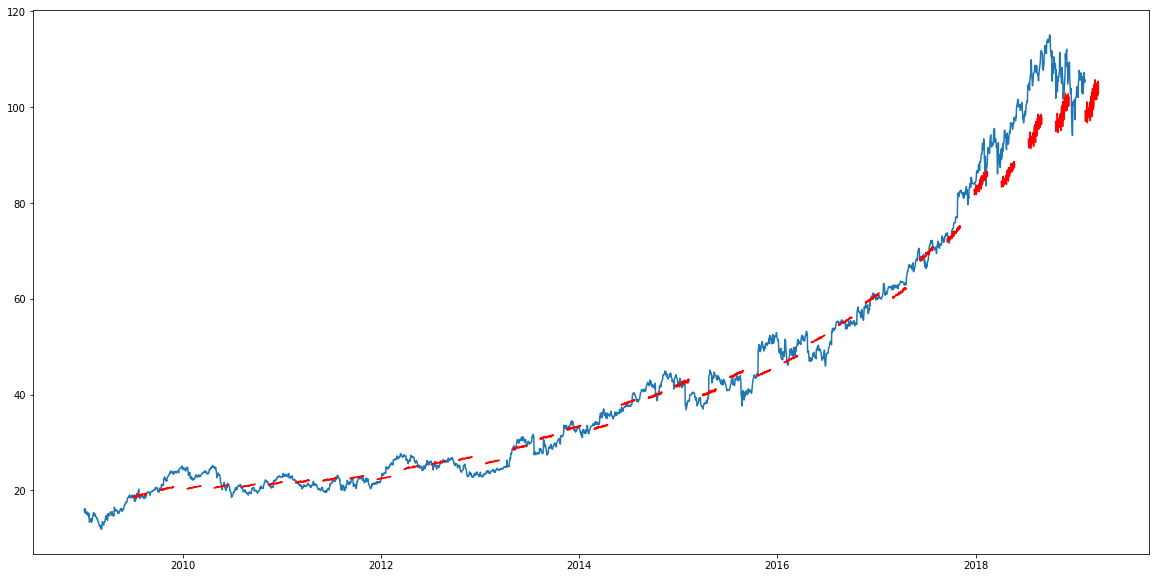

In [57]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

ax.plot(data.data_frame['price'])
for c, series in enumerate(pred_series):
    ax.plot(series, color='r')
    
plt.show()